In [12]:
import os 
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]="SimHei"
plt.rcParams["axes.unicode_minus"]=True
fig_path="../latex/tex/figures/"
import seaborn as sns
from hyperopt import tpe,fmin,Trials,hp,rand,anneal,space_eval


from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import lightgbm as lgbm
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_absolute_error as mae 
from lightgbm import LGBMRegressor

In [13]:
data=pd.read_csv("data/data_1.csv")
## 把Gender,Subject 等 构造成 Category
categorys=["Gender","SKIN","SPORT","Activity","Subject"]
for category in categorys:
    data[category]=data[category].astype("category")
data

,chest_ACC_x,chest_ACC_y,chest_ACC_z,chest_Resp,chest_ECG,wrist_ACC_x,wrist_ACC_y,wrist_ACC_z,wrist_BVP,wrist_TEMP,WEIGHT,Gender,AGE,HEIGHT,SKIN,SPORT,Rpeaks,Activity,Label,Subject
0,0.8564,-0.0678,-0.3656,4.441833,0.015610,-0.765625,-0.078125,0.671875,7.28,32.13,78.0,m,34,182.0,3,6,0,0,49.611369,S1
1,0.8514,-0.0654,-0.3688,4.876709,-0.015747,-0.765625,-0.078125,0.671875,-11.36,32.16,78.0,m,34,182.0,3,6,1,0,49.611369,S1
2,0.8514,-0.0662,-0.3708,3.340149,-0.008743,-0.765625,-0.078125,0.671875,-51.27,32.16,78.0,m,34,182.0,3,6,0,0,49.611369,S1
3,0.8594,-0.0632,-0.3640,0.740051,-0.339523,-0.750000,-0.078125,0.671875,5.65,32.16,78.0,m,34,182.0,3,6,0,0,49.611369,S1
4,0.8510,-0.0674,-0.3694,-1.475525,-0.089905,-0.765625,-0.078125,0.671875,34.34,32.16,78.0,m,34,182.0,3,6,0,0,49.611369,S1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517951,0.8878,0.0122,-0.2330,2.789307,-0.281845,-0.468750,0.859375,0.093750,1.68,33.99,79.0,m,28,183.0,2,5,0,0,79.664230,S15
517952,0.8962,-0.0184,-0.2280,0.563049,0.075851,-0.609375,0.890625,0.265625,-16.38,33.99,79.0,m,28,183.0,2,5,1,0,79.664230,S15
517953,0.9010,0.0006,-0.2102,-1.075745,0.017166,-0.468750,0.531250,-0.562500,13.43,33.99,79.0,m,28,183.0,2,5,0,0,79.664230,S15
517954,0.8906,-0.0124,-0.2238,-2.117920,-0.304184,-0.375000,0.406250,-0.843750,-5.89,33.99,79.0,m,28,183.0,2,5,0,0,79.664230,S15


In [14]:
data.groupby("Subject").count()

,chest_ACC_x,chest_ACC_y,chest_ACC_z,chest_Resp,chest_ECG,wrist_ACC_x,wrist_ACC_y,wrist_ACC_z,wrist_BVP,wrist_TEMP,WEIGHT,Gender,AGE,HEIGHT,SKIN,SPORT,Rpeaks,Activity,Label
Subject,,,,,,,,,,,,,,,,,,,
S1,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848,36848
S10,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592,42592
S11,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192,36192
S12,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656,31656
S13,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544,36544
S14,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832,35832
S15,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756,31756
S2,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820,32820
S3,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964,34964


In [15]:
import gc
import pdb
import time as times
def time_scale(S1):
## 尝试增加时间窗口长度，一个人运动完之后需要10min来恢复正常，可以认为一直到600s之前的都会对这玩意产生影响
    print("处理",pd.unique(S1.Subject),"shape:",S1.shape)
    # return S1
    dup_columns=["chest_ACC_x",	"chest_ACC_y","chest_ACC_z","chest_Resp","chest_ECG","wrist_ACC_x","wrist_ACC_y","wrist_ACC_z","wrist_BVP","wrist_TEMP"]
    for time in range(8,20,8):
        time1=times.time()
        temp1=S1.iloc[0:1,:].loc[:,dup_columns]
        while temp1.shape[0]<=time:
            temp1=temp1.append(temp1,ignore_index=True)
        temp2=S1.iloc[:-time,:].loc[:,dup_columns]
        temp=temp1.iloc[:time,:].append(temp2,ignore_index=True)
        temp.columns=[i+str(time) for i in dup_columns]
        S1.index=[i for i in range(S1.shape[0])]
        S1=pd.concat([S1,temp],axis=1)
        del temp1,temp2
        gc.collect()
        print(time,S1.shape,times.time()-time1)
    return S1
if os.path.exists("data/data_scale.csv"):
    data_scale=pd.read_csv("data/data_scale.csv")
    categorys=["Gender","SKIN","SPORT","Activity","Subject"]
    for category in categorys:
        data_scale[category]=data_scale[category].astype("category")
else:
    data_scale=data.groupby("Subject",as_index=False).apply(time_scale)
    data_scale.to_csv("data/data_scale.csv",index=False)
data_scale=data_scale.reindex(np.arange(data_scale.shape[0]))
data_scale.index=[i for i in range(data_scale.shape[0])]

In [16]:
X_columns=[i for i in data_scale.columns if i!="Label"]
y_columns=["Label"]
X=data_scale.loc[:,X_columns]
y=data_scale.loc[:,y_columns]
display(X,y)

,chest_ACC_x,chest_ACC_y,chest_ACC_z,chest_Resp,chest_ECG,wrist_ACC_x,wrist_ACC_y,wrist_ACC_z,wrist_BVP,wrist_TEMP,...,chest_ACC_x16,chest_ACC_y16,chest_ACC_z16,chest_Resp16,chest_ECG16,wrist_ACC_x16,wrist_ACC_y16,wrist_ACC_z16,wrist_BVP16,wrist_TEMP16
0,0.8564,-0.0678,-0.3656,4.441833,0.015610,-0.765625,-0.078125,0.671875,7.28,32.13,...,0.8564,-0.0678,-0.3656,4.441833,0.015610,-0.765625,-0.078125,0.671875,7.28,32.13
1,0.8514,-0.0654,-0.3688,4.876709,-0.015747,-0.765625,-0.078125,0.671875,-11.36,32.16,...,0.8564,-0.0678,-0.3656,4.441833,0.015610,-0.765625,-0.078125,0.671875,7.28,32.13
2,0.8514,-0.0662,-0.3708,3.340149,-0.008743,-0.765625,-0.078125,0.671875,-51.27,32.16,...,0.8564,-0.0678,-0.3656,4.441833,0.015610,-0.765625,-0.078125,0.671875,7.28,32.13
3,0.8594,-0.0632,-0.3640,0.740051,-0.339523,-0.750000,-0.078125,0.671875,5.65,32.16,...,0.8564,-0.0678,-0.3656,4.441833,0.015610,-0.765625,-0.078125,0.671875,7.28,32.13
4,0.8510,-0.0674,-0.3694,-1.475525,-0.089905,-0.765625,-0.078125,0.671875,34.34,32.16,...,0.8564,-0.0678,-0.3656,4.441833,0.015610,-0.765625,-0.078125,0.671875,7.28,32.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517951,0.9470,-0.0794,-0.1462,1.518250,-0.039688,-0.812500,0.984375,-0.093750,-80.15,31.75,...,0.9006,-0.0170,-0.2080,-1.312256,-0.006180,-0.875000,-0.515625,0.093750,19.72,31.71
517952,0.8508,-0.0174,-0.1756,1.301575,1.003189,-0.640625,0.296875,-0.609375,48.99,31.79,...,0.9022,-0.0178,-0.2104,-2.284241,-0.041428,-0.859375,-0.531250,0.125000,38.08,31.75
517953,0.9962,-0.0230,-0.1532,1.683044,0.200272,-0.312500,0.000000,-0.890625,57.36,31.79,...,0.8954,-0.0114,-0.2056,-2.828979,-0.026413,-0.859375,-0.531250,0.125000,-47.00,31.75
517954,0.9714,0.0306,-0.1814,2.107239,-0.077042,-0.359375,0.062500,-0.796875,-15.11,31.79,...,0.8990,-0.0090,-0.2138,-3.048706,0.041885,-0.859375,-0.531250,0.125000,-40.67,31.75


,Label
0,49.611369
1,49.611369
2,49.611369
3,49.611369
4,49.611369
...,...
517951,87.263414
517952,87.263414
517953,87.263414
517954,87.263414


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42, stratify = y)


In [36]:
file_path=""

class Machine(object):
    """定义一个Machine的类。
    本Machine类的思路如下：
    任何一个特殊的模型如SVC都可以用来建立Machine类
    通过调用self.headquater方法可以完成从hyperopt参数寻优一直到模型报告的过程
    如果想象征性的跑一跑代码看看能不能跑通，把HyperoptTrain(self,max_evals=50)中的50改为较小的数字即可（比如3）"""
    def __init__(self,clf,params:dict,
                 X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
        self.X_train=X_train
        self.y_train=y_train
        self.X_test=X_test
        self.y_test=y_test
        self.clf=clf
        self.params=params
    def Report(self):
        """报告分类性能的函数,同时画出分类结果ROC函数"""
        y_train_predict=self.clf.predict(self.X_train)
        y_predict=self.clf.predict(self.X_test)
        train_mae=mean_absolute_error(y_true=self.y_train,y_pred=y_train_predict)
        train_mse=mean_squared_error(y_true=self.y_train,y_pred=y_train_predict)
        train_r2=r2_score(y_true=self.y_train,y_pred=y_train_predict)
        test_mae=mean_absolute_error(y_true=self.y_test,y_pred=y_predict)
        test_mse=mean_squared_error(y_true=self.y_test,y_pred=y_predict)
        test_r2=r2_score(y_true=self.y_test,y_pred=y_predict)
        
        print("="*60)    
        print("train数据集上模型精度指标(MAE,MSE,R2):",[train_mae,train_mse,train_r2])
        print("test数据集上模型精度指标(MAE,MSE,R2):",[test_mae,test_mse,test_r2])
        print("="*60)    
    def objective(self,params):
        self.clf.set_params(**params)
        res=np.nanmean(cross_val_score(self.clf,self.X_train,self.y_train,scoring="r2",
                                   cv=5))
        return -res
    def HyperoptTrain(self,max_evals=50):
        """使用tpe.suggest寻找最优参数"""
        trials=Trials()
        if self.model_name!="SVR" and self.model_name!="KNeighborsRegressor":
            self.params["random_state"]=hp.choice("random_state",[0]) #加一个random_state操作
        best_params=fmin(fn=self.objective,space=self.params,
                         algo=tpe.suggest,max_evals=max_evals,trials=trials)
        best_params=space_eval(self.params, best_params)
        np.save(file_path+self.model_name+"best_params",best_params)
        print("best params:\n",best_params)
        self.clf.set_params(**best_params)
        self.clf.fit(self.X_train,self.y_train)
        return self.clf
    def headquarter(self,model_name):
        """中心调度器，完成从模型训练直到模型报告的所有工作"""
        self.model_name=model_name
        self.clf=self.HyperoptTrain()
        print(model_name,"模型","训练完成，下面是模型报告：")
        self.Report()
        return self.clf

In [19]:

clf_LGBM=LGBMRegressor()
params_LGBM={
        "boosting_type":hp.choice("boosting_type",['gbdt']),
        'max_depth': hp.randint('max_depth', 12),
        'num_leaves':  hp.choice('num_leaves', np.arange(30, 150,10, dtype=int)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.choice("n_estimators",np.arange(100, 300, 50,dtype=int))
    }
LGBM_machine=Machine(clf_LGBM,params_LGBM)
clf_LGBM=LGBM_machine.headquarter(model_name="LGBM")
# print(r2_score(y_test,y_predict),mae(y_test,y_predict))

100%|██████████| 50/50 [36:36<00:00, 43.92s/trial, best loss: -0.9426877146019429]
best params:
 {'boosting_type': 'gbdt', 'learning_rate': 0.19762496404467517, 'max_depth': 0, 'n_estimators': 250, 'num_leaves': 90, 'random_state': 0}
LGBM 模型 训练完成，下面是模型报告：
train数据集上模型精度指标(MAE,MSE,R2): [3.432683183560428, 21.353170921102926, 0.9590040985598653]
test数据集上模型精度指标(MAE,MSE,R2): [3.8235833200803526, 28.181932915049483, 0.9458935748490613]


In [20]:
importance=np.argsort(clf_LGBM.feature_importances_)
display(clf_LGBM.feature_importances_[np.int32(importance[-1:-10:-1])])
np.array(X_columns)[np.int32(importance[-1:-10:-1])]

array([1931, 1613, 1406, 1294, 1175,  794,  762,  753,  737])

array(['wrist_TEMP', 'wrist_TEMP16', 'Subject', 'wrist_TEMP8', 'Activity',
       'chest_ACC_z', 'wrist_ACC_y', 'chest_ACC_z16', 'wrist_ACC_y16'],
      dtype='<U13')

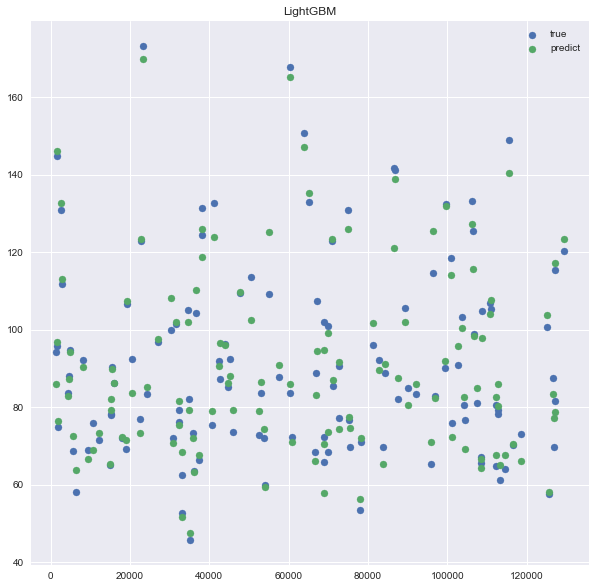

In [21]:
plt.style.use("seaborn")
def Show_precision(X_test:pd.DataFrame or np.array,y_test:np.array,model,title):
    """展示最终的精确度"""
    plt.figure(figsize=(10,10))
    y_predict=model.predict(X_test)
    ## 采样
    tot_num=len(y_test)
    sample=np.random.randint(0,tot_num,size=[round(0.001*tot_num)]).tolist()

    plt.scatter(sample,y_test[sample],label="true")
    plt.scatter(sample,y_predict[sample],label="predict")
    plt.legend()
    plt.title(title)
    plt.show()

Show_precision(X_test,y_test.to_numpy(),clf_LGBM,"LightGBM")

In [22]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import RadiusNeighborsRegressor,KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42, stratify = y)
X_train=pd.DataFrame(X_train.to_numpy(),index=[i for i in range(X_train.shape[0])],columns=X.columns)
X_test=pd.DataFrame(X_test.to_numpy(),index=[i for i in range(X_test.shape[0])],columns=X.columns)
OneHot=OneHotEncoder()
# def Onehottransform(X):
    # """输入X，返回一个已经转变好的"""
X_train_cate=X_train.loc[:,categorys].copy()
X_test_cate=X_test.loc[:,categorys].copy()
X_train_trans=OneHot.fit_transform(X_train_cate).todense()
X_train_trans=pd.DataFrame(X_train_trans,index=[i for i in range(X_train_trans.shape[0])],columns=["cate"+str(i) for i in range(X_train_trans.shape[1])])
X_test_trans=OneHot.transform(X_test_cate).todense()
X_test_trans=pd.DataFrame(X_test_trans)
X_test_trans=X_test_trans.reindex_like(X_train_trans)
X_train=pd.merge(left=X_train.drop(categorys,axis=1),right=X_train_trans,left_index=True,right_index=True)
X_test=pd.merge(left=X_test.drop(categorys,axis=1),right=X_test_trans,left_index=True,right_index=True)
X_test.fillna(value=0,inplace=True)
# pipe=Pipeline([("Onehot",OneHotEncoder()),
                # ("Neibor",RadiusNeighborsRegressor())])
X_train=StandardScaler().fit_transform(X_train)
X_test=StandardScaler().fit_transform(X_test)

### 线性回归算法

In [37]:
from sklearn.linear_model import ElasticNet
clf_Ela=ElasticNet()
param_Ela={
        "alpha":hp.uniform("alpha",0.1,0.9),
        # "penalty":hp.choice("penalty",['elasticnet']),
        "l1_ratio":hp.uniform("l1_ration",0.1,0.9)
        # 'solver': hp.choice("solver",['saga'])    
}
Ela_machine=Machine(clf_Ela,param_Ela)
clf_ELA=Ela_machine.headquarter(model_name="ElasticNet")


100%|██████████| 50/50 [10:20<00:00, 12.42s/trial, best loss: -0.7953732703442157]
best params:
 {'alpha': 0.1018466623415494, 'l1_ratio': 0.8964946481996604, 'random_state': 0}
ElasticNet 模型 训练完成，下面是模型报告：
train数据集上模型精度指标(MAE,MSE,R2): [7.701296327696663, 106.55659539583384, 0.7954222490521667]
test数据集上模型精度指标(MAE,MSE,R2): [15.490086265373222, 425.0640435536067, 0.1839205661934218]


ElasticNet(alpha=0.1018466623415494, l1_ratio=0.8964946481996604,
           random_state=0)